# Example 1:Hinge and Square Loss
This example try to show how to use our PLQ Composite Decomposition tool to decompose a given loss function and use ReHLine to do classification.

Given a loss function $L(z)=max(max(1-z,0)),\frac{1}{2} (1-z)^2 )$

In [1]:
import numpy as np

z = np.linspace(-2, 2, 100)
L1 = np.maximum(1 - z, 0)
L2 = 0.5 * (1 - z) ** 2

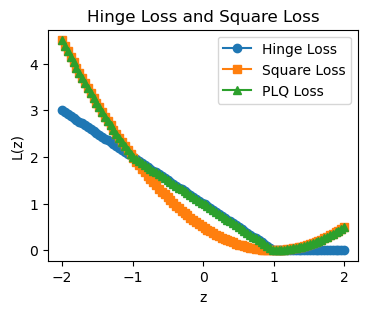

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 3))
plt.plot(z, L1, marker='o', label='Hinge Loss')
plt.plot(z, L2, marker='s', label='Square Loss')
plt.plot(z, np.maximum(L1, L2), marker='^', label='PLQ Loss')
plt.legend()
plt.xlabel('z')
plt.ylabel('L(z)')
plt.title('Hinge Loss and Square Loss')
plt.show()

# 1.Data Generation

In [3]:
from plqcom.PLQLoss import PLQLoss
from plqcom.PLQProperty import plq_to_rehloss
from plqcom.ReHProperty import affine_transformation
from rehline import ReHLine
from rehline._base import relu, rehu

Generate a random classification dataset, where $X \in \mathbb{R}^{1000 \times 3}$ and $y \in \mathbb\{ -1, 1\}^{1000}$

In [4]:
# Generate a random classification dataset
n, d, C = 1000, 3, 0.5
np.random.seed(1024)
X = np.random.randn(n, d)
beta = np.random.randn(d)
y = np.sign(X.dot(beta) + np.random.randn(n))

First 10 samples of the dataset

In [5]:
X[:10], y[:10]

(array([[ 2.12444863,  0.25264613,  1.45417876],
        [ 0.56923979,  0.45822365, -0.80933344],
        [ 0.86407349,  0.20170137, -1.87529904],
        [-0.56850693, -0.06510141,  0.80681666],
        [-0.5778176 ,  0.57306064, -0.33667496],
        [ 0.29700734, -0.37480416,  0.15510474],
        [ 0.70485719,  0.8452178 , -0.65818079],
        [ 0.56810558,  0.51538125, -0.61564998],
        [ 0.92611427, -1.28591285,  1.43014026],
        [-0.4254975 , -0.40257712,  0.60410409]]),
 array([ 1., -1., -1., -1., -1.,  1., -1., -1.,  1.,  1.]))

In [6]:
X[:10].dot(beta)

array([ 4.63095617, -1.53086335, -3.77183917,  1.49927261, -1.1677152 ,
        0.56448038, -1.12647624, -1.09186115,  3.93541798,  1.1463427 ])

# 2. Create and Decompose the PLQ Loss

Create the PLQ Loss object with the given quad_coef only.(minimax form)

In [7]:
plqloss_1 = PLQLoss(
    quad_coef={'a': np.array([0., 0., 0.5]), 'b': np.array([0., -1., -1.]), 'c': np.array([0., 1., 0.5])},
    form='minimax')

We can also create the PLQ Loss object with the given quad_coef and cutpoints.(plq form)

In [8]:
plqloss_2 = PLQLoss(
    quad_coef={'a': np.array([0.5, 0., 0.5]), 'b': np.array([-1., -1., -1.]), 'c': np.array([0.5, 1., 0.5])},
    cutpoints=np.array([-1., 1.]),
    form='plq')

Convert the PLQ Loss to ReHLoss by calling its method _2ReHLoss()

In [9]:
rehloss_1 = plq_to_rehloss(plqloss_1)
rehloss_2 = plq_to_rehloss(plqloss_2)

In [10]:
rehloss_1.relu_coef, rehloss_1.relu_intercept, rehloss_1.rehu_cut, rehloss_1.rehu_coef, rehloss_1.rehu_intercept
rehloss_2.relu_coef, rehloss_2.relu_intercept, rehloss_2.rehu_cut, rehloss_2.rehu_coef, rehloss_2.rehu_intercept

(array([[-1.],
        [-1.]]),
 array([[ 1.],
        [-1.]]),
 array([[inf],
        [inf]]),
 array([[-1.],
        [ 1.]]),
 array([[-1.],
        [-1.]]))

In [11]:
rehloss_1.rehu_coef==rehloss_2.rehu_coef

array([[ True],
       [ True]])

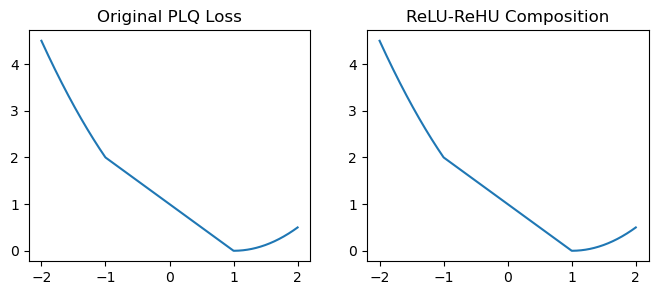

In [12]:
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
Z = np.linspace(-2, 2, 1000)
L = plqloss_1(Z)
plt.plot(Z, L)
plt.title('Original PLQ Loss')

plt.subplot(1, 2, 2)
relu_coef, relu_intercept = rehloss_1.relu_coef, rehloss_1.relu_intercept
rehu_cut, rehu_coef, rehu_intercept = rehloss_1.rehu_cut, rehloss_1.rehu_coef, rehloss_1.rehu_intercept
Reh = np.sum(rehu(rehu_coef * Z + rehu_intercept, rehu_cut), axis=0) + np.sum(relu(relu_coef * Z + relu_intercept),
                                                                              axis=0)
plt.plot(Z, Reh)
plt.title('ReLU-ReHU Composition')
plt.show()

# 3.Broadcast to all samples

For this classication problem,
$L(z)= max(max(1-z,0)),\frac{1}{2} (1-z)^2 )$
$L_i(z_i)=\frac{1}{2} max(max(1-y_i z_i,0)),\frac{1}{2} (1-y_i z_i)^2 )$
Compare $L_i(z_i)$ with $L(z)$, we can find that $L_i(z_i)=\frac{1}{2}L(y_i z_i)$ which is a affine transformation of $L(z)$ with $p=y_i, q=0,c=\frac{1}{2}$.

In [13]:
rehloss = affine_transformation(rehloss_1, n=X.shape[0], c=C, p=y, q=0)

In [14]:
rehloss.relu_coef, rehloss.relu_intercept, rehloss.rehu_cut, rehloss.rehu_coef, rehloss.rehu_intercept

(array([[-0.5,  0.5,  0.5, ...,  0.5,  0.5, -0.5],
        [-0.5,  0.5,  0.5, ...,  0.5,  0.5, -0.5]]),
 array([[ 0.5,  0.5,  0.5, ...,  0.5,  0.5,  0.5],
        [-0.5, -0.5, -0.5, ..., -0.5, -0.5, -0.5]]),
 array([[inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf]]),
 array([[-0.70710678,  0.70710678,  0.70710678, ...,  0.70710678,
          0.70710678, -0.70710678],
        [ 0.70710678, -0.70710678, -0.70710678, ..., -0.70710678,
         -0.70710678,  0.70710678]]),
 array([[-0.70710678, -0.70710678, -0.70710678, ..., -0.70710678,
         -0.70710678, -0.70710678],
        [-0.70710678, -0.70710678, -0.70710678, ..., -0.70710678,
         -0.70710678, -0.70710678]]))

# 4. Use ReHLine to solve the problem

In [15]:
clf = ReHLine(loss={'name': 'custom'}, C=C)
clf.U, clf.V, clf.Tau, clf.S, clf.T = rehloss.relu_coef, rehloss.relu_intercept, rehloss.rehu_cut, rehloss.rehu_coef, rehloss.rehu_intercept
clf.fit(X=X)
print('sol privided by rehline: %s' % clf.coef_)
print('decision_function: %s' % clf.decision_function([[.1,.2,.3]]))
print('precision: %s' % (np.sum(np.sign(X.dot(clf.coef_))==y)/n))

sol privided by rehline: [ 0.27532288 -0.01385027  0.86725151]
decision_function: [0.28493769]
precision: 0.875
